#  <font color='#0366d6'> Case scenario </font><br>

<font size="2">
    
- A young couple wishes to explore the current house market in 10 South Eastern Brisbane suburbs (*'Kuraby', 'Eight Mile Plains','Eight Mile Plains', 'Wishart', 'Sunnybank', 'Eight Mile Plains', 'Algester', 'Upper Mount Gravatt','Kuraby','Algester','Runcorn'*).<br>

* They plan to buy a 3 or 4 bedroom house in one of the suburbs next year to settle in.<br>

* They are currently having a house in the north side of Brisbane, and wish to find a house with a price around high 500K - mid 600K in the selected SE Brisbane area. <br>

- This project aims to provide the couple with a better understanding to the following questions through analysis of the number of houses sold and the median house prices across the 10 suburbs, so as to pick 3-4 ideal suburbs to explore their future homes.<br>

###  <font color='#0366d6'> Key questions to answer </font>

* Over the last 10 years (2011-2020), how many properties are sold yearly by the top 3 property types?<br>
* Over the last 4 years (2017-2020), how many houses were sold by bedroom numbers? And what's the overall trend among these suburbs? <br>
* What is the min, max and median sold price for House with 3 or 4 bedrooms in each suburb? <br>
* Are there any correlations between the house sold price and other factors?<br>

###  <font color='#0366d6'> Project scope</font>

* Compared the summary median price data of the sold houses from each suburb between Nov 2019-Dec 2020 on [REA](https://www.realestate.com.au/sold/) and [Domain](https://www.domain.com.au/) to understand the price differences between these 2 sites.
* Compared with the website traffic and [Canstar domain ratings](https://www.canstarblue.com.au/stores-services/real-estate-vs-domain/) between the 2 sites, to decide which site to pull the sold property listing details for in-depth analysis.<br>
* Upon selecting REA as the data source, we dived deeper to analyze the total number of properties sold between 2006-2020.<br>
* However, due to some of the key suburbs, which the clients is interested in, doesn't have data captured before 2017, we focused on analyzing the number of sold properties and the median price for 3-4 bedroom houses between 2017-2020.<br>
* Next we switched back to examine all data collected over past 14 years, to explore what factors may have a (linear) correlation with the house price.<br>
* Finally, based on the above analysis, a selection of suburbs is recommended to the couple, to assist them make an informed decision on which suburb(s) they should focus on exploring for their house purchase next year.<br>
</font>

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import pprint
from collections import defaultdict
import glob
import seaborn as sns
import plotly_express as px
import matplotlib
from matplotlib import pyplot as plt

# <font color='#0366d6'> REA realestate.com.au | suburb | property median price data <font>
- Access API data 

In [2]:
# A list of suburb to scrape the house buy and rent data from realestate.com.au
suburbs=['runcorn','sunnybank','sunnybank hills','eight mile plains', 
         'kuraby', 'upper mount gravatt', 'wishart', 'coopers plains','calamvale', 'algester']

In [3]:
#Create a loop to collect the house buy and rent data from each suburb

results=[]

for s in suburbs:
    #define API URL
    url_part1='https://investor-api.realestate.com.au/v2/states/qld/suburbs/'
    url_part2='.json?embed=suburb_geo'

    url=url_part1+s+url_part2
    
    #Request the URL and parse the JSON data
    response=requests.get(url) #request the url
    response.raise_for_status() #raise exception if invaid response
    #print('Response Code: ',response.status_code) #check the request code  

    result=response.json() #create a json object ofthe results
    results.append(result)

In [4]:
#check if the results list has collected all 10 suburbs data from the json file
suburb_keys=[list(r.keys())[0] for r in results] 
print(suburb_keys)

['RUNCORN-4113', 'SUNNYBANK-4109', 'SUNNYBANK HILLS-4109', 'EIGHT MILE PLAINS-4113', 'KURABY-4112', 'UPPER MOUNT GRAVATT-4122', 'WISHART-4122', 'COOPERS PLAINS-4108', 'CALAMVALE-4116', 'ALGESTER-4115']


In [5]:
#Preview a sample suburb "Runcorn" json data
#pprint.pprint(results[1]) #print the result

## Create a suburb based house price data frame

In [6]:
property_type=results[0]['RUNCORN-4113']['property_types'] #check what property types available in the listing
print(property_type.keys()) #2 Types - House, Unit

#We only look for bedrooms with 3+ bedrooms
house_bed_num=['ALL', '3', '4', '5+']

dict_keys(['HOUSE', 'UNIT'])


In [7]:
#Create a loop to access the house buy/rent data based on the num of bedrooms from each suburb
house_bedrooms_data=[]

for key in range(len(suburb_keys)):
    
    suburbs_pc=suburb_keys[key]  #suburb name + postal_code
    suburb_data=results[key][suburbs_pc] #access the suburb dict
    house_suburb_data=suburb_data['property_types']['HOUSE'] #access the house data in the dict
    house_bedrooms=house_suburb_data['bedrooms'] #access the house bedrooms info in the dict
    
    hbk=list(house_bedrooms.keys()) #check if the suburb has house data with less than 3 bedrooms, if so, remove them
    if '0' in hbk:  #remove record with bedroom num=0
        house_bedrooms.pop('0')
    elif '1' in hbk: #remove record with bedroom num=1
        house_bedrooms.pop('1')
    elif '2' in hbk:#remove record with bedroom num=2
        house_bedrooms.pop('2')
    else:
        house_bedrooms
    
    house_bedrooms_data.append(house_bedrooms)    

In [8]:
# Buid a house buy and rent dataframe based on the num of bedrooms from each suburb

df_houses_list=[]
for i in range(10):
    suburb=suburbs[i]
    house_data=house_bedrooms_data[i]
    
    houses_data_list=[]
    
    for x in range(4): #use loop to return the house data based on the num of bedrooms (num=3,4, 5+ or ALL)
        num=house_bed_num[x]
        houses_data=house_data[num]['investor_metrics']
            
        houses_data['bedrooms']=num # add a new column to show the bedroom number
        df_houses=pd.DataFrame(houses_data, index=np.arange(1))#store the house data in a dataframe
        houses_data_list.append(df_houses) #append all house dfs for a suburb into a list


    df_houses=pd.concat(houses_data_list,axis=0, ignore_index=True) #merge all dataframes in the list into 1 for each suburb

    df_houses['suburb']=str(suburb) #add a new colum to show the suburb name

    cols=df_houses.columns.to_list() # 10 columns
    cols=cols[-1:]+cols[-2:-1]+cols[:-2] #move the last 2 colunns ("suburb, bedrooms") to the front of dataframe
    df_houses=df_houses[cols]
    df_houses_list.append(df_houses) #append all suburb unit dfs into a list
    

df_houses=pd.concat(df_houses_list,axis=0, ignore_index=True) #merge all suburb dataframes into 1
df_houses['property_type']='house'
df_houses.head()    


suburb bedrooms  median_sold_price median_sold_price_five_years_ago  \
0    runcorn      ALL           569000.0                           523500   
1    runcorn        3           552000.0                           485000   
2    runcorn        4           615000.0                           550000   
3    runcorn       5+           766500.0                           640000   
4  sunnybank      ALL           755000.0                           690000   

   median_rental_price  rental_yield annual_growth  rental_demand  \
0                417.5      0.038155         0.017         742.58   
1                390.0      0.036739         0.026         821.38   
2                470.0      0.039740         0.023         828.09   
3                530.0      0.035956         0.037        2015.98   
4                430.0      0.029616         0.018         597.14   

   rental_properties  sold_properties  sold_properties_five_years_ago  \
0                222               78                             174   
1                108               31                              86   
2                 91               33                              58   
3                 17                6                              14   
4                257               59                             147   

  property_type  
0         house  
1         house  
2         house  
3         house  
4         house

In [9]:
df_houses.dtypes # we noticed that "median_sold_price_five_years_ago" and "annual_growth" are shown as string

suburb                               object
bedrooms                             object
median_sold_price                   float64
median_sold_price_five_years_ago     object
median_rental_price                 float64
rental_yield                        float64
annual_growth                        object
rental_demand                       float64
rental_properties                     int64
sold_properties                       int64
sold_properties_five_years_ago        int64
property_type                        object
dtype: object

In [10]:
df_houses.isnull().sum() #check if there are null values

suburb                              0
bedrooms                            0
median_sold_price                   0
median_sold_price_five_years_ago    1
median_rental_price                 0
rental_yield                        0
annual_growth                       1
rental_demand                       0
rental_properties                   0
sold_properties                     0
sold_properties_five_years_ago      0
property_type                       0
dtype: int64

In [11]:
df_houses.fillna(0, inplace=True) #replace null value with 0
df_houses.head()

suburb bedrooms  median_sold_price  median_sold_price_five_years_ago  \
0    runcorn      ALL           569000.0                          523500.0   
1    runcorn        3           552000.0                          485000.0   
2    runcorn        4           615000.0                          550000.0   
3    runcorn       5+           766500.0                          640000.0   
4  sunnybank      ALL           755000.0                          690000.0   

   median_rental_price  rental_yield  annual_growth  rental_demand  \
0                417.5      0.038155          0.017         742.58   
1                390.0      0.036739          0.026         821.38   
2                470.0      0.039740          0.023         828.09   
3                530.0      0.035956          0.037        2015.98   
4                430.0      0.029616          0.018         597.14   

   rental_properties  sold_properties  sold_properties_five_years_ago  \
0                222               78                             174   
1                108               31                              86   
2                 91               33                              58   
3                 17                6                              14   
4                257               59                             147   

  property_type  
0         house  
1         house  
2         house  
3         house  
4         house

In [12]:
#convert "median_sold_price_five_years_ago" and "annual_growth" into float data types
dict={"suburb":str, "bedrooms":str,
      "median_sold_price":np.float64,
     "median_sold_price_five_years_ago":np.float64,
     "median_rental_price":np.float64,
      "annual_growth":np.float64,
      "rental_demand":np.float64,
      "rental_properties":np.int64,
      "sold_properties":np.int64,
      "sold_properties_five_years_ago":np.int64,
      "property_type": str}

In [13]:
#check the data type again
df_houses.apply(dict)
df_houses.dtypes

suburb                               object
bedrooms                             object
median_sold_price                   float64
median_sold_price_five_years_ago    float64
median_rental_price                 float64
rental_yield                        float64
annual_growth                       float64
rental_demand                       float64
rental_properties                     int64
sold_properties                       int64
sold_properties_five_years_ago        int64
property_type                        object
dtype: object

In [14]:
df_rea_data=df_houses
df_rea_data.rename({'property_type':'type'},axis=1, inplace=True)
df_rea_data.head()

suburb bedrooms  median_sold_price  median_sold_price_five_years_ago  \
0    runcorn      ALL           569000.0                          523500.0   
1    runcorn        3           552000.0                          485000.0   
2    runcorn        4           615000.0                          550000.0   
3    runcorn       5+           766500.0                          640000.0   
4  sunnybank      ALL           755000.0                          690000.0   

   median_rental_price  rental_yield  annual_growth  rental_demand  \
0                417.5      0.038155          0.017         742.58   
1                390.0      0.036739          0.026         821.38   
2                470.0      0.039740          0.023         828.09   
3                530.0      0.035956          0.037        2015.98   
4                430.0      0.029616          0.018         597.14   

   rental_properties  sold_properties  sold_properties_five_years_ago   type  
0                222               78                             174  house  
1                108               31                              86  house  
2                 91               33                              58  house  
3                 17                6                              14  house  
4                257               59                             147  house

# <font color='#0366d6'> Domain.com.au | suburb | property median price data </font>
- Access data collected by using a web scraper 

Note: Unlike **REA** (https://www.realestate.com.au), where the median price can be accessed directly from the page or API, <br>**Domain.com.au** (https://www.domain.com.au) shows some of the detailed property data (such as yearly median price trend) in a folded menu, which is more difficult and time consuming to scrape using Python. 

Hence I used a web scraping tool to obtain the property data only from 10 suburbs to speed up the process.<br>
Let's import the data from domain.com.au and have a preview.

In [15]:
#1. Market Trend Data

In [16]:
domain_url=r"data\domain_market_trend.xlsx"
df_domain_data=pd.read_excel(domain_url,sheet_name='mkt_trend_all')
df_domain_data.head(5)

suburb  bedrooms   type median_sold_price Avg days on market  \
0  runcorn         2  house                 -                  -   
1  runcorn         3  house             $455k            67 days   
2  runcorn         4  house             $611k            50 days   
3  runcorn         5  house                 -                  -   
4  runcorn         2   unit                 -                  -   

  Clearance rate  sold_properties  
0              -                5  
1            0.5               58  
2           0.41               48  
3              -                8  
4              -                3

Let's drop rows where the "Median price", "Avg days on market", and "Clearance rate" are missing. <br>
As most of them are from the property type (Unit) and bedrooms (less than 3 or greater than 5) that we are not interested.

In [17]:
#First, replace any cells containing "-" in these 3 columns with NaN value

cols_with_dash=["median_sold_price", "Avg days on market", "Clearance rate"]

for x in cols_with_dash:
    df_domain_data[x]=df_domain_data[x].replace("-", np.nan)
    
df_domain_data.head()

suburb  bedrooms   type median_sold_price Avg days on market  \
0  runcorn         2  house               NaN                NaN   
1  runcorn         3  house             $455k            67 days   
2  runcorn         4  house             $611k            50 days   
3  runcorn         5  house               NaN                NaN   
4  runcorn         2   unit               NaN                NaN   

   Clearance rate  sold_properties  
0             NaN                5  
1            0.50               58  
2            0.41               48  
3             NaN                8  
4             NaN                3

In [18]:
#Second, drop all rows where NaN values are found in the 3 columns
df_domain_data.dropna(subset=["median_sold_price", "Avg days on market","Clearance rate"], how='any', inplace=True)
df_domain_data=df_domain_data.reset_index(drop=True)
df_domain_data.head()

suburb  bedrooms   type median_sold_price Avg days on market  \
0            runcorn         3  house             $455k            67 days   
1            runcorn         4  house             $611k            50 days   
2  eight mile plains         4  house             $750k            54 days   
3  eight mile plains         5  house             $852k            70 days   
4          sunnybank         3  house             $655k           169 days   

   Clearance rate  sold_properties  
0            0.50               58  
1            0.41               48  
2            0.43               31  
3            0.06               30  
4            0.08               27

In [19]:
#check data types
#We noticed that "median_sold_price", "Avg days on market" need to updated to numeric values.
df_domain_data.dtypes

suburb                 object
bedrooms                int64
type                   object
median_sold_price      object
Avg days on market     object
Clearance rate        float64
sold_properties         int64
dtype: object

In [20]:
#remove the dollar $, texts such as days, so wecan convert these 2 cols into numeric values
from string import digits
digits+="."
print(digits)

0123456789.


In [21]:
def remove_puncs(string_piece):
    if string_piece:
        string=str(string_piece).strip()
        string =''.join([num for num in string if num in digits])
        return string

In [22]:
string_cols=["median_sold_price", "Avg days on market"]
numeric_cols = defaultdict(pd.Series)

for col in string_cols:
    numeric_cols[col]=df_domain_data[col].apply(lambda x: pd.to_numeric(remove_puncs(x), 'coerce')).astype(np.float64)

In [23]:
numeric_cols.keys()    

dict_keys(['median_sold_price', 'Avg days on market'])

In [24]:
df_domain_data=df_domain_data.drop(list(numeric_cols.keys()), axis=1)
df_domain_data.head()

suburb  bedrooms   type  Clearance rate  sold_properties
0            runcorn         3  house            0.50               58
1            runcorn         4  house            0.41               48
2  eight mile plains         4  house            0.43               31
3  eight mile plains         5  house            0.06               30
4          sunnybank         3  house            0.08               27

In [25]:
df_domain_data=df_domain_data.assign(**numeric_cols)
df_domain_data['median_sold_price']=df_domain_data['median_sold_price']*1000 
df_domain_data.iloc[6,5]=df_domain_data.iloc[6,5]*1000 #this is a house type with 1.2M as meidan price

In [26]:
df_domain_data.head(7)

suburb  bedrooms   type  Clearance rate  sold_properties  \
0            runcorn         3  house            0.50               58   
1            runcorn         4  house            0.41               48   
2  eight mile plains         4  house            0.43               31   
3  eight mile plains         5  house            0.06               30   
4          sunnybank         3  house            0.08               27   
5          sunnybank         4  house            0.41               28   
6          sunnybank         5  house            0.20               14   

   median_sold_price  Avg days on market  
0           455000.0                67.0  
1           611000.0                50.0  
2           750000.0                54.0  
3           852000.0                70.0  
4           655000.0               169.0  
5           725000.0                96.0  
6          1020000.0               151.0

# <font color='#0366d6'> Which sites should we rely on? REA vs DOMAIN </font>

Through a quick check on the median house prices collected from REA and Domain, we noticed there's a big difference between the median sold price for Runcorn (3 bedroom house) from these 2 sites.<br>
-  REA | Runcorn | House | 3 Bedrooms | Median House Price - 550K <br> 
-  Domain | Runcorn | House |3 Bedrooms | Median House Price - 455K <br> 	

So let's compare the median sold price differences between REA and Domain for houses (w/ 3-4 bedrooms), which is what our clients are most intersted in.
Then decide which site we should rely on in the future to check more detailed property info.<br>

### Compare Median Price of House with 3 and 4 bedrooms  

In [27]:
# REA data

In [28]:
#First, read in the REA data again
df_rea_data.head()

suburb bedrooms  median_sold_price  median_sold_price_five_years_ago  \
0    runcorn      ALL           569000.0                          523500.0   
1    runcorn        3           552000.0                          485000.0   
2    runcorn        4           615000.0                          550000.0   
3    runcorn       5+           766500.0                          640000.0   
4  sunnybank      ALL           755000.0                          690000.0   

   median_rental_price  rental_yield  annual_growth  rental_demand  \
0                417.5      0.038155          0.017         742.58   
1                390.0      0.036739          0.026         821.38   
2                470.0      0.039740          0.023         828.09   
3                530.0      0.035956          0.037        2015.98   
4                430.0      0.029616          0.018         597.14   

   rental_properties  sold_properties  sold_properties_five_years_ago   type  
0                222               78                             174  house  
1                108               31                              86  house  
2                 91               33                              58  house  
3                 17                6                              14  house  
4                257               59                             147  house

In [29]:
#group the rea data by 3 cols to view the house median_sold_price from each suburb
groups_rea=df_rea_data.groupby(['type','bedrooms','suburb'])['median_sold_price'].mean()
groups_rea

type   bedrooms  suburb             
house  3         algester                491000.0
                 calamvale               554750.0
                 coopers plains          550000.0
                 eight mile plains       607550.0
                 kuraby                  427750.0
                 runcorn                 552000.0
                 sunnybank               655000.0
                 sunnybank hills         554000.0
                 upper mount gravatt     630000.0
                 wishart                 637500.0
       4         algester                560500.0
                 calamvale               650000.0
                 coopers plains          668000.0
                 eight mile plains       754000.0
                 kuraby                  681000.0
                 runcorn                 615000.0
                 sunnybank               765000.0
                 sunnybank hills         658000.0
                 upper mount gravatt     695000.0
             

Because our clients are most interested in houses with 3 or 4 bedrooms, let's extract the data from the grouped view.

In [30]:
# REA House Median Price - 3 or 4 bedroms

rea_bdrs=groups_rea.loc[('house',('3','4'))] #select property type=house,bedrooms =3 or 4
rea_bdrs=rea_bdrs.sort_index(level=(0,1,2)) #sort the multi-index series by ascending order for calculation later
rea_bdrs

type   bedrooms  suburb             
house  3         algester               491000.0
                 calamvale              554750.0
                 coopers plains         550000.0
                 eight mile plains      607550.0
                 kuraby                 427750.0
                 runcorn                552000.0
                 sunnybank              655000.0
                 sunnybank hills        554000.0
                 upper mount gravatt    630000.0
                 wishart                637500.0
       4         algester               560500.0
                 calamvale              650000.0
                 coopers plains         668000.0
                 eight mile plains      754000.0
                 kuraby                 681000.0
                 runcorn                615000.0
                 sunnybank              765000.0
                 sunnybank hills        658000.0
                 upper mount gravatt    695000.0
                 wishart        

In [31]:
#Domain data

In [32]:
#Read in domain data again
df_domain_data.head()

suburb  bedrooms   type  Clearance rate  sold_properties  \
0            runcorn         3  house            0.50               58   
1            runcorn         4  house            0.41               48   
2  eight mile plains         4  house            0.43               31   
3  eight mile plains         5  house            0.06               30   
4          sunnybank         3  house            0.08               27   

   median_sold_price  Avg days on market  
0           455000.0                67.0  
1           611000.0                50.0  
2           750000.0                54.0  
3           852000.0                70.0  
4           655000.0               169.0

In [33]:
#group the rea data by 3 cols to view the house median_sold_price from each suburb
groups_domain=df_domain_data.groupby(['type','bedrooms','suburb'])['median_sold_price'].mean()
groups_domain

type   bedrooms  suburb             
house  3         algester                477000.0
                 runcorn                 455000.0
                 sunnybank               655000.0
                 sunnybank hills         550000.0
                 upper mount gravatt     600000.0
                 wishart                 652000.0
       4         calamvale               641000.0
                 eight mile plains       750000.0
                 kuraby                  653000.0
                 runcorn                 611000.0
                 sunnybank               725000.0
                 sunnybank hills         660000.0
                 upper mount gravatt     709000.0
                 wishart                 789000.0
       5         calamvale               775000.0
                 eight mile plains       852000.0
                 sunnybank              1020000.0
                 sunnybank hills         873000.0
                 wishart                 958000.0
Name: median_

Because our clients are most interested in houses with 3 or 4 bedrooms, let's extract the data from Domain as well

In [34]:
# Domain House Median Price - 3 or 4 bedroms

domain_bdrs=groups_domain.loc[('house',(3,4))]  #select property type=house,bedrooms =3 or 4
domain_bdrs=domain_bdrs.sort_index(level=(0,1,2))  #select property type=house,bedrooms =3 or 4
domain_bdrs

type   bedrooms  suburb             
house  3         algester               477000.0
                 runcorn                455000.0
                 sunnybank              655000.0
                 sunnybank hills        550000.0
                 upper mount gravatt    600000.0
                 wishart                652000.0
       4         calamvale              641000.0
                 eight mile plains      750000.0
                 kuraby                 653000.0
                 runcorn                611000.0
                 sunnybank              725000.0
                 sunnybank hills        660000.0
                 upper mount gravatt    709000.0
                 wishart                789000.0
Name: median_sold_price, dtype: float64

<font color='blue'>Summary - house median price - 3 bedrooms (see horizontal bar chart below)<br>
- In general, REA price is much higher than Domain price
- Also, Domain don't have median price data for 4 suburbs (calamvale, coopers plains and eight mile plans, kuraby)</font>

<AxesSubplot:ylabel='suburb'>

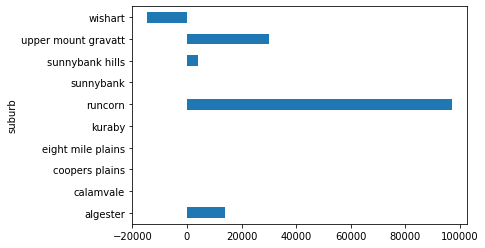

In [35]:
#REA House Median Price 
rea_bdr3=rea_bdrs.loc[('house','3')]

#Domain House Median Price - 3 bedroms
domain_bdr3=domain_bdrs.loc[('house',3)]

#compare the House Median Price between 3 bedroms (REA vs Domain)
median_price_diff3=rea_bdr3-domain_bdr3
median_price_diff3.plot(kind='barh')

<font color='blue'>Summary - house median price - 4 bedrooms (see horizontal bar chart below) <br>
- In general, REA price is again much higher than Domain price
- Also, domain doesn't have median price data for 2 suburb (algester, coopers plains)</font>

<AxesSubplot:ylabel='suburb'>

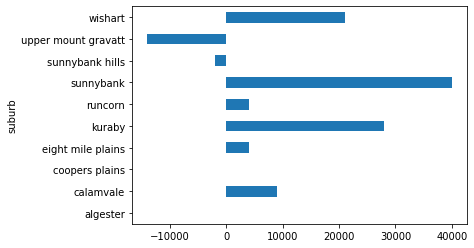

In [36]:
#REA House Median Price - 4 bedroms
rea_bdr4=rea_bdrs.loc[('house','4')]

#Domain House Median Price - 4 bedroms
domain_bdr4=domain_bdrs.loc[('house', 4)]

#compare the House Median Price between 4 bedrooms (REA vs Domain)
median_price_diff4=rea_bdr4-domain_bdr4
median_price_diff4.plot(kind='barh')

### Compare Website Traffic and Overall Rating
<font color='blue'>We will quickly compare these 2 sites on the following metrics to help us make an informed decision:</font>

-- 1 Website Traffic & Other KPIs (Unique Visitors, Visits, Time Spent per Visit, Bounce Rate) -SEMRUSH www.semrush.com<br>
-- 2 Overall site rating - Canstar https://www.canstarblue.com.au/stores-services/real-estate-vs-domain/

Other info: https://community.cubbi.com.au/blog/realestate-com-au-versus-domain-which-site-is-best-to-advertise-my-property

**1) <font color='blue'>Traffic Comparison<font>**

In [37]:
#1. Website Traffic & Other KPI

web_url=r'data\Traffic_Rating.xlsx'

df_web=pd.read_excel(web_url, sheet_name='SEMRUSH_traffic')
df_web

Domain  Visits (M)  Unique Visitors (M)  Pages / Visit  \
0  realestate.com.au        50.5                 12.3           4.26   
1      domain.com.au        16.3                  5.8           3.73   

   Avg. Visit Duration (Mins)  Bounce Rate  
0                       10.30       0.3754  
1                       12.27       0.5398

In [38]:
df_web.plot(kind='bar')

<AxesSubplot:>

**<font color='blue'>Summary<font>**
    
- By comparing the web traffic KPIs, we can see **REA (realestate.com.au) has 8X more traffic** than Domain by **Visits**.
- **REA** also has **2X more traffic** than Domain by **Unique Visitors**.
- Though Domain has slightly higher Avg. Visit Duration length (12 mins) than REA (10 mins), **REA** showed **much lower bounce rate (38%) than Domain (54%)**. This indicates visitors are more likely to stay around and view more than 1 pages on REA.
    
<font color='blue'>In summary - REA has much stronger traffic and also better user engagement than Domain.</font>

**2) <font color='blue'>Site Overall Ratings<font>**

In [39]:
#2. Compare the Site Overall Ratings from Canstar data

df_rating=pd.read_excel(web_url, sheet_name='CANSTAR_rating')
df_rating

Rated brands  Overall satisfaction  Range of properties  \
0  realestate.com.au                     5                    5   
1      domain.com.au                     4                    4   

   Ease of site navigation  Quality of information available  Image accuracy  \
0                        5                                 5               4   
1                        4                                 4               4   

   Tools and calculators  Total Score  
0                      5           29  
1                      4           24

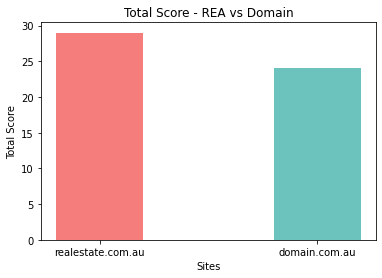

In [40]:
#Show the overall rating in colored bar chart

df_total_score=df_rating.iloc[:,-1]
plt.bar(df_rating['Rated brands'],df_rating['Total Score'], color=['#F57D7C', '#6CC2BD'],width=0.4)
plt.xlabel("Sites")
plt.ylabel("Total Score")
plt.title("Total Score - REA vs Domain")

plt.show()

**<font color='blue'>Summary<font>**
    
- By comparing the overall site ratings from Canstar, we can see **REA (realestate.com.au) outranked Domain** by **"Total Score"**.
- REA - total score : 29
- Domain - total score: 24
- REA led the rating in 5 out of 6 categories (Overall satisfaction, Overall satisfaction, Range of properties, Ease of site navigation, Quality of information available and Tools and calculators)
    
<font color='blue'>In summary - REA has a higher overall performance rating than Domain.<font>

### **<font color='blue'>Conclusion</font>**
- Based on the comparisons from web traffic and overall site performance overview of 2 sites,<br>
it's clear that **REA** is the site that we would go for more detailed property data analysis. 

Next Step
- Scrap the property listing of the 10 suburbs from REA site

# <font color='#0366d6'> REA Property Data Analysis </font>

Note:
- I used a web scraping tool to obtain the property listing data from the 10 suburbs to speed up the process.<br>
- Let's import the data from domain.com.au and have a preview.

## Combine files and create a dataframe for all suburbs

Import the scraped 10 suburbs property listings data from RAE with a loop and combine the files into a single dataframe

We will take the following steps to read in multiple files
1. Get a list of filenames (or sheets)
2. Turn those into a list of dataframes
3. Add the filename as a column to each dataframe
4. Combine the dataframes into one big huge dataframe



In [41]:
#Getting a list of filenames

filenames=glob.glob('Data\\realestate.com.au_SOLD*.csv')
filenames

['Data\\realestate.com.au_SOLD_Algester.csv',
 'Data\\realestate.com.au_SOLD_Calamvale.csv',
 'Data\\realestate.com.au_SOLD_Coopers_Plains.csv',
 'Data\\realestate.com.au_SOLD_Eight_Mile_Plains.csv',
 'Data\\realestate.com.au_SOLD_Kuraby.csv',
 'Data\\realestate.com.au_SOLD_Runcorn.csv',
 'Data\\realestate.com.au_SOLD_Sunnybank.csv',
 'Data\\realestate.com.au_SOLD_Sunnybank_Hills.csv',
 'Data\\realestate.com.au_SOLD_Upper_Mt_Gravatt.csv',
 'Data\\realestate.com.au_SOLD_Wishart.csv']

In [42]:
#Turn those files into a list of dataframes
df_lists=[pd.read_csv(filename, encoding='ISO-8859-1') for filename in filenames]
len(df_lists)

10

In [43]:
#Combining multiple dataframes
df_all=pd.concat(df_lists, ignore_index=True)
df_all.shape #check dataframe shape

(9993, 14)

In [44]:
#preview the dataframe
df_all.head(3)

Address  \
0     58 Dalmeny Street, Algester   
1     162 Delathin Road, Algester   
2  20 Springwater Place, Algester   

                                       Property_Info  \
0  https://www.realestate.com.au/sold/property-ho...   
1  https://www.realestate.com.au/sold/property-ho...   
2  https://www.realestate.com.au/sold/property-ho...   

                                          Agent_logo  \
0  https://i2.au.reastatic.net/340x64/d4ded41d266...   
1  https://i2.au.reastatic.net/340x64/72065f86a98...   
2  https://i2.au.reastatic.net/340x64/adf93bc0d60...   

                           Agent  \
0  Michelle Huston & Mark Kearns   
1                    JJ Macalino   
2                  Andrea Manson   

                                         Agent_photo Status      Price  \
0  https://i2.au.reastatic.net/150x200/8a5badd53f...   Sold  $700,000    
1  https://i2.au.reastatic.net/150x200/ff4dfb2ff3...   Sold  $600,000    
2  https://i2.au.reastatic.net/150x200/d84dba8712...   Sold  $577,800    

   Bedrooms  Bathrooms  Car_park  Size Size_unit   Type            Sold_date  
0       2.0        2.0       2.0   549        m²  House  Sold on 15 Dec 2020  
1       4.0        2.0       2.0   570        m²  House  Sold on 11 Dec 2020  
2       4.0        3.0       2.0   604        m²  House  Sold on 11 Dec 2020

In [45]:
# there are 4 addresses contain ",,", 
#which will break the split function to be used to extract Suburb name, let's replace them with ",".

df_all['Address']=df_all['Address'].str.strip().str.replace(",,", ",") 

In [46]:
#extract the Suburb name from the df_all, and add a new column as "Surburb"

df_all['Suburb']=df_all['Address'].str.split(',', expand=True)[1].str.strip() 

In [47]:
#Split the Suburb string and to extract the last item as the Suburb name
df_all['Suburb']=[row[-1] for row in df_all['Address'].str.split(',')]

In [48]:
#Check the suburbs names
df_all['Suburb'].value_counts()

 Sunnybank              1500
 Algester               1250
 Sunnybank Hills        1250
 Eight Mile Plains      1250
 Kuraby                 1075
 Wishart                1026
 Upper Mount Gravatt    1000
 Coopers Plains          696
 Calamvale               550
 Runcorn                 396
Name: Suburb, dtype: int64

- When checking the data types in the data frame, there are some duplicates and missing values across multiple columns.
- We can also see the Price, Size are of the string type (instead of numeric values)
- Furthermore, the Sold_date is string type instead of datetime type. 
- So the tasks to perform next are to remove duplicates, fill the missing values, convert Price and Size dtypes to float64 and turn Sold_date to datetime type.

In [49]:
#check the data types
df_all.dtypes

Address           object
Property_Info     object
Agent_logo        object
Agent             object
Agent_photo       object
Status            object
Price             object
Bedrooms         float64
Bathrooms        float64
Car_park         float64
Size              object
Size_unit         object
Type              object
Sold_date         object
Suburb            object
dtype: object

In [50]:
df_all.isna().sum()/len(df_all)*100 #check the missing values in each column by %

Address           0.000000
Property_Info     0.000000
Agent_logo       10.387271
Agent            46.922846
Agent_photo      64.535175
Status            0.000000
Price             0.000000
Bedrooms          2.952066
Bathrooms         2.952066
Car_park          5.273692
Size             21.985390
Size_unit        20.074052
Type              0.000000
Sold_date         0.060042
Suburb            0.000000
dtype: float64

In [51]:
#check the df shape
df_all.shape

(9993, 15)

## Data cleansing first

### Drop duplicates

In [52]:
df_all.duplicated().sum()

87

In [53]:
df_all.drop_duplicates(keep='first', inplace=True)
df_all.shape

(9906, 15)

In [54]:
df_all.drop_duplicates(subset=['Address'], keep='first', inplace=True)
df_all.shape

(8588, 15)

### Convert " Price, Size" columns to numeric datatype

In [55]:
# Check the Price column and we can see 2 issues:
# - there are 5% of total rows showing "Contact agent", so we can't evaluate the house price in this case
# - there's a dollar sign in the price column
    
df_all['Price'].value_counts(normalize=True)

Contact agent    0.052632
$650,000         0.006754
$550,000         0.006404
$400,000         0.006055
$750,000         0.005589
                   ...   
$477,000         0.000116
$1,188,880       0.000116
$642,500         0.000116
$792,000         0.000116
$537,888         0.000116
Name: Price, Length: 2059, dtype: float64

In [56]:
#drop the rows where Price shown as "Contact agent"

df_all=df_all[df_all['Price']!='Contact agent']
df_all.shape  #we have dropped 452 rows

(8136, 15)

In [57]:
df_all['Size'].isna().sum() #Size column has~1.8K rows has no value

1784

In [58]:
df_all['Size']=df_all['Size'].fillna(0) #Fill the null value with 0 
df_all['Size'].isna().sum()  #Now, the Size column doesn't have any null value

0

In [59]:
#Remove the dollar $ from Price, so we can convert Price and Size into numeric values using the "remove_puncs function"

str_cols=['Price', 'Size']
num_cols=defaultdict(pd.Series)

for c in str_cols:
    num_cols[c]=df_all[c].apply(lambda i:pd.to_numeric(remove_puncs(i), 'coerce')).astype(np.float64)

In [60]:
num_cols.keys()

dict_keys(['Price', 'Size'])

In [61]:
df_all=df_all.drop(list(num_cols.keys()), axis=1) #drop the 2 original columns - Price and Size
df_all.head()

Address  \
0     58 Dalmeny Street, Algester   
1     162 Delathin Road, Algester   
2  20 Springwater Place, Algester   
3      8 Limewood Place, Algester   
4      27 Owenia Street, Algester   

                                       Property_Info  \
0  https://www.realestate.com.au/sold/property-ho...   
1  https://www.realestate.com.au/sold/property-ho...   
2  https://www.realestate.com.au/sold/property-ho...   
3  https://www.realestate.com.au/sold/property-ho...   
4  https://www.realestate.com.au/sold/property-ho...   

                                          Agent_logo  \
0  https://i2.au.reastatic.net/340x64/d4ded41d266...   
1  https://i2.au.reastatic.net/340x64/72065f86a98...   
2  https://i2.au.reastatic.net/340x64/adf93bc0d60...   
3  https://i2.au.reastatic.net/340x64/72065f86a98...   
4  https://i2.au.reastatic.net/340x64/adf93bc0d60...   

                           Agent  \
0  Michelle Huston & Mark Kearns   
1                    JJ Macalino   
2                  Andrea Manson   
3                   Gonnie Nahar   
4                  Andrea Manson   

                                         Agent_photo Status  Bedrooms  \
0  https://i2.au.reastatic.net/150x200/8a5badd53f...   Sold       2.0   
1  https://i2.au.reastatic.net/150x200/ff4dfb2ff3...   Sold       4.0   
2  https://i2.au.reastatic.net/150x200/d84dba8712...   Sold       4.0   
3  https://i2.au.reastatic.net/150x200/4b77daff58...   Sold       3.0   
4  https://i2.au.reastatic.net/150x200/d84dba8712...   Sold       4.0   

   Bathrooms  Car_park Size_unit   Type            Sold_date     Suburb  
0        2.0       2.0        m²  House  Sold on 15 Dec 2020   Algester  
1        2.0       2.0        m²  House  Sold on 11 Dec 2020   Algester  
2        3.0       2.0        m²  House  Sold on 11 Dec 2020   Algester  
3        1.0       3.0        m²  House  Sold on 08 Dec 2020   Algester  
4        2.0       2.0        m²  House  Sold on 04 Dec 2020   Algester

In [62]:
df_all=df_all.assign(**num_cols) #reassign processed columns back to the dataframe
df_all.head()

Address  \
0     58 Dalmeny Street, Algester   
1     162 Delathin Road, Algester   
2  20 Springwater Place, Algester   
3      8 Limewood Place, Algester   
4      27 Owenia Street, Algester   

                                       Property_Info  \
0  https://www.realestate.com.au/sold/property-ho...   
1  https://www.realestate.com.au/sold/property-ho...   
2  https://www.realestate.com.au/sold/property-ho...   
3  https://www.realestate.com.au/sold/property-ho...   
4  https://www.realestate.com.au/sold/property-ho...   

                                          Agent_logo  \
0  https://i2.au.reastatic.net/340x64/d4ded41d266...   
1  https://i2.au.reastatic.net/340x64/72065f86a98...   
2  https://i2.au.reastatic.net/340x64/adf93bc0d60...   
3  https://i2.au.reastatic.net/340x64/72065f86a98...   
4  https://i2.au.reastatic.net/340x64/adf93bc0d60...   

                           Agent  \
0  Michelle Huston & Mark Kearns   
1                    JJ Macalino   
2                  Andrea Manson   
3                   Gonnie Nahar   
4                  Andrea Manson   

                                         Agent_photo Status  Bedrooms  \
0  https://i2.au.reastatic.net/150x200/8a5badd53f...   Sold       2.0   
1  https://i2.au.reastatic.net/150x200/ff4dfb2ff3...   Sold       4.0   
2  https://i2.au.reastatic.net/150x200/d84dba8712...   Sold       4.0   
3  https://i2.au.reastatic.net/150x200/4b77daff58...   Sold       3.0   
4  https://i2.au.reastatic.net/150x200/d84dba8712...   Sold       4.0   

   Bathrooms  Car_park Size_unit   Type            Sold_date     Suburb  \
0        2.0       2.0        m²  House  Sold on 15 Dec 2020   Algester   
1        2.0       2.0        m²  House  Sold on 11 Dec 2020   Algester   
2        3.0       2.0        m²  House  Sold on 11 Dec 2020   Algester   
3        1.0       3.0        m²  House  Sold on 08 Dec 2020   Algester   
4        2.0       2.0        m²  House  Sold on 04 Dec 2020   Algester   

      Price   Size  
0  700000.0  549.0  
1  600000.0  570.0  
2  577800.0  604.0  
3  515100.0  597.0  
4  546500.0  639.0

In [63]:
#Fix the remained price and size issues

# For example, the Price value low (407) or too high.
# Some of the house size was under 2 mm2, because they were measured in HA.
# Some of the property listed as House but the size showed and address info showed they are actually Townhouses.

In [64]:
sorted(df_all.Price.value_counts().index)
#check the lowest price 407
df_all[df_all.Price==407]

Address                                      Property_Info  \
9783  10 Winthrop, Wishart  https://www.realestate.com.au/sold/property-ho...   

                                             Agent_logo  \
9783  https://i2.au.reastatic.net/340x64/6771cd17f45...   

                      Agent Agent_photo Status  Bedrooms  Bathrooms  Car_park  \
9783  Agent: William Hooper         NaN   Sold       4.0        1.0       2.0   

     Size_unit   Type            Sold_date    Suburb  Price  Size  
9783       NaN  House  Sold on 20 Mar 2013   Wishart  407.0   NaN

In [65]:
#Update the crazy price value/size value to the correct data
df_all.at[9783,'Price']=515000

df_all.at[4772,'Price']=640000

df_all.at[2471,'Price']=332000

df_all.at[2495,'Price']=546000

df_all.at[4642,'Price']=640000

df_all.at[4684,'Price']=580000

df_all.at[4689,'Price']=415000

df_all.at[4710,'Price']=526000

df_all.at[4772,'Price']=640000

df_all.at[4684,'Size']=451

In [66]:
df_all.dtypes

Address           object
Property_Info     object
Agent_logo        object
Agent             object
Agent_photo       object
Status            object
Bedrooms         float64
Bathrooms        float64
Car_park         float64
Size_unit         object
Type              object
Sold_date         object
Suburb            object
Price            float64
Size             float64
dtype: object

In [67]:
#Updated the size to mm2

df_all.Size=[x*10000 if x <=2 else x+0 for x in df_all.Size]

In [68]:
#Now we see from the address that some of the houses with land size under 200 are actually Townhouses.
#So let's update them to the correct property type.

df_townhouse=df_all[(df_all.Size<=200)&(df_all['Type']=='House')]
df_townhouse[:3]

Address  \
323  4/157 Dalmeny Street, Algester   
344     8/72 Learoyd Road, Algester   
390   24/18 Ackama Street, Algester   

                                         Property_Info  \
323  https://www.realestate.com.au/sold/property-ho...   
344  https://www.realestate.com.au/sold/property-ho...   
390  https://www.realestate.com.au/sold/property-ho...   

                                            Agent_logo        Agent  \
323  https://i2.au.reastatic.net/340x64/91a8160f9d1...  EMMA WALTER   
344  https://i2.au.reastatic.net/340x64/3fbb0a1151f...          NaN   
390  https://i2.au.reastatic.net/340x64/3fbb0a1151f...          NaN   

                                           Agent_photo Status  Bedrooms  \
323  https://i2.au.reastatic.net/150x200/e4191f782b...   Sold       3.0   
344                                                NaN   Sold       4.0   
390                                                NaN   Sold       3.0   

     Bathrooms  Car_park Size_unit   Type            Sold_date     Suburb  \
323        2.0       1.0        m²  House  Sold on 05 Jun 2017   Algester   
344        2.0       2.0        m²  House  Sold on 15 Feb 2017   Algester   
390        2.0       1.0        m²  House  Sold on 11 Jul 2016   Algester   

        Price   Size  
323  316000.0  163.0  
344  315000.0   94.0  
390  307000.0  173.0

In [69]:
#We will update the property type to Townhouse if the type = House, and the size is <= 200, also the address contains "/"

th_index=df_all[(df_all.Size<=200)&(df_all['Type']=='House')].Address.str.contains('/').index
th_index

for ind in th_index:
    df_all.at[ind,'Type']='Townhouse'

### Convert column "Sold_date" to datetime type

In [70]:
#less than 1 % of the Sold_date value are missing, we can drop those rows as well

df_all.dropna(axis=0,subset=['Sold_date'], inplace=True) 
df_all=df_all.reset_index(drop=True)
df_all.head()

Address  \
0     58 Dalmeny Street, Algester   
1     162 Delathin Road, Algester   
2  20 Springwater Place, Algester   
3      8 Limewood Place, Algester   
4      27 Owenia Street, Algester   

                                       Property_Info  \
0  https://www.realestate.com.au/sold/property-ho...   
1  https://www.realestate.com.au/sold/property-ho...   
2  https://www.realestate.com.au/sold/property-ho...   
3  https://www.realestate.com.au/sold/property-ho...   
4  https://www.realestate.com.au/sold/property-ho...   

                                          Agent_logo  \
0  https://i2.au.reastatic.net/340x64/d4ded41d266...   
1  https://i2.au.reastatic.net/340x64/72065f86a98...   
2  https://i2.au.reastatic.net/340x64/adf93bc0d60...   
3  https://i2.au.reastatic.net/340x64/72065f86a98...   
4  https://i2.au.reastatic.net/340x64/adf93bc0d60...   

                           Agent  \
0  Michelle Huston & Mark Kearns   
1                    JJ Macalino   
2                  Andrea Manson   
3                   Gonnie Nahar   
4                  Andrea Manson   

                                         Agent_photo Status  Bedrooms  \
0  https://i2.au.reastatic.net/150x200/8a5badd53f...   Sold       2.0   
1  https://i2.au.reastatic.net/150x200/ff4dfb2ff3...   Sold       4.0   
2  https://i2.au.reastatic.net/150x200/d84dba8712...   Sold       4.0   
3  https://i2.au.reastatic.net/150x200/4b77daff58...   Sold       3.0   
4  https://i2.au.reastatic.net/150x200/d84dba8712...   Sold       4.0   

   Bathrooms  Car_park Size_unit   Type            Sold_date     Suburb  \
0        2.0       2.0        m²  House  Sold on 15 Dec 2020   Algester   
1        2.0       2.0        m²  House  Sold on 11 Dec 2020   Algester   
2        3.0       2.0        m²  House  Sold on 11 Dec 2020   Algester   
3        1.0       3.0        m²  House  Sold on 08 Dec 2020   Algester   
4        2.0       2.0        m²  House  Sold on 04 Dec 2020   Algester   

      Price   Size  
0  700000.0  549.0  
1  600000.0  570.0  
2  577800.0  604.0  
3  515100.0  597.0  
4  546500.0  639.0

In [71]:
df_all['Sold_date']=df_all['Sold_date'].str.replace('Sold on ', '') #remove the text "Sold on"
df_all.Sold_date=pd.to_datetime(df_all.Sold_date) #conver the Sold_date into datetime type 

In [72]:
Sold_year=df_all['Sold_date'].dt.year #extract year from the Sold_date
df_all['Sold_year']=Sold_year #assign the new Sold_year column back to df_all

In [73]:
df_all['Sold_year'].astype(np.int64) #convert year datatype to integer

0       2020
1       2020
2       2020
3       2020
4       2020
        ... 
8126    2015
8127    2015
8128    2015
8129    2015
8130    2014
Name: Sold_year, Length: 8131, dtype: int64

### Fill the missing values in any other columns 

In [74]:
#3 columns - 'Agent_logo', 'Agent', 'Agent_photo', we can simply fill the cell with "unknown"

agent_cols=['Agent_logo', 'Agent', 'Agent_photo']
for agent in agent_cols:
    df_all[agent]=df_all[agent].fillna('unknown')

In [75]:
#Column - "Size_unit" , we know all the landsize was measured by m², so we can fill all missing values with m²

df_all['Size_unit']='m²'

In [76]:
# 2 Columns - "Bedrooms" and "Bathrooms" has ~3% missing values each, as we need the Bedroom num to compare the price, and the missing value means
#these rows of data may not be useful for us. So we can drop them.

df_all.dropna(axis=0, subset=['Bedrooms', 'Bathrooms'], inplace=True)
df_all.shape

(7932, 16)

In [77]:
# Column - "Car_park", we can fill the missing value with 0, as this is not so important in this case

df_all['Car_park'].fillna(0, inplace=True)

In [78]:
#Column - "Type" - we see "Apartment", "Unit" are listed seperatedly. As we are more interested in House type, let's combined these 2 types into "Unit"
df_all['Type'].value_counts()

House                   6317
Townhouse               1232
Apartment                143
Unit                     136
Villa                     78
Block Of Units             7
Duplex/Semi-Detached       5
Other                      5
Retirement Living          4
Acreage                    3
Warehouse                  1
Terrace                    1
Name: Type, dtype: int64

In [79]:
apt=df_all['Type']=='Apartment'
df_all['Type'].copy()[apt]='Unit'
df_all['Type'].value_counts()

House                   6317
Townhouse               1232
Apartment                143
Unit                     136
Villa                     78
Block Of Units             7
Duplex/Semi-Detached       5
Other                      5
Retirement Living          4
Acreage                    3
Warehouse                  1
Terrace                    1
Name: Type, dtype: int64

In [80]:
#check if there are any other columns still have missing values
df_all['Size']=df_all['Size'].fillna(0)
df_all.isnull().sum()

Address          0
Property_Info    0
Agent_logo       0
Agent            0
Agent_photo      0
Status           0
Bedrooms         0
Bathrooms        0
Car_park         0
Size_unit        0
Type             0
Sold_date        0
Suburb           0
Price            0
Size             0
Sold_year        0
dtype: int64

In [81]:
#fix the suburb
df_all.Suburb.value_counts()

 Eight Mile Plains      1139
 Sunnybank Hills        1125
 Algester               1011
 Upper Mount Gravatt     894
 Wishart                 878
 Sunnybank               738
 Kuraby                  717
 Calamvale               535
 Coopers Plains          502
 Runcorn                 393
Name: Suburb, dtype: int64

In [82]:
df_all.to_csv("df_all_10.csv", index=False)
df_all.shape

(7932, 16)

## Analyze the house listing data in 10 suburbs to answer the following key questions:

* Over the last 10 years (2011-2020), how many properties are sold yearly by the top 3 property types?<br>
* Over the last 4 years (2017-2020), how many houses were sold by bedroom numbers? And what's the overall trend in these suburbs? <br>
* What is the min, max and median sold price for House with 3 or 4 bedrooms in each suburb?<br>
* Are there any correlations between the house sold price and other factors?<br>


In [83]:
#Sort the grouped view 
groups=df_all.groupby(['Type', 'Sold_year']).Address.count().sort_values(ascending=False)
groups=groups.sort_index(level=(0,1), ascending=False)
groups

Type       Sold_year
Warehouse  2020          1
Villa      2020          6
           2019         12
           2018         17
           2017         13
                        ..
Apartment  2009          1
           2008          1
Acreage    2016          1
           2015          1
           2014          1
Name: Address, Length: 82, dtype: int64

We only want to check the most popular property types are:
- House
- Townhouse
- Unit 

So, let's narrow the table view to these 3 types

In [84]:
types=['House','Townhouse','Unit']
types_sold_yearly={}

for t in types:
    sold_yearly=groups.loc[(t)]
    types_sold_yearly[t]=sold_yearly
    
df_sold_yearly=pd.DataFrame(types_sold_yearly)

#As we only want to check the last 10 years trend, so we will narrow the Sold_year to 2011-2020
df_sold_yearly=df_sold_yearly[-10:]

#convert all values into integer
df_sold_yearly.apply(lambda x: x.astype(np.int64)) 

House  Townhouse  Unit
Sold_year                        
2011          91          6     1
2012         132         18     2
2013         334         53     8
2014         660        114     7
2015         804        109    22
2016         853        138    19
2017         952        199    14
2018         885        233    26
2019         776        172    17
2020         698        177    16

In [85]:
df_sold_yearly=df_sold_yearly[['House', 'Townhouse', 'Unit']]

- Clearly, we can see from the line chart below, the number of houses sold over the last 10 years had a significant increase, followed by Townhouse and Units
- The number of houses sold reached its peak (~1K) around 2017-2018 then trended downward.
- The number of townhouse saw a slow and steady increase while units had remained flat most of the time

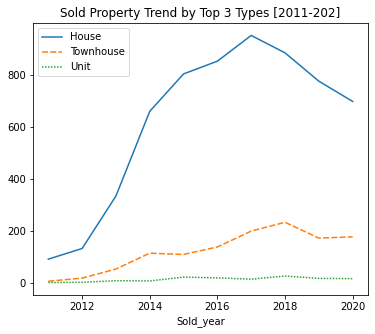

In [86]:
fig0 = plt.figure(figsize=(6,5))
ax=fig0.add_subplot()
ax=sns.lineplot(data=df_sold_yearly).set_title('Sold Property Trend by Top 3 Types [2011-202]')

#### Now, we want to trend the view by 3 property types in each of the 10 suburbs at all times

In [87]:
groups1=df_all.groupby(['Suburb','Sold_year','Type']).Address.count().sort_values(ascending=False)
groups1=groups.sort_index(level=(0,1), ascending=False)

#This allows us to have a quick view on how many properties were sold by top 3 types each year
groups1.loc[(['House','Townhouse', 'Unit'])] 

Type       Sold_year
House      2020         698
           2019         776
           2018         885
           2017         952
           2016         853
           2015         804
           2014         660
           2013         334
           2012         132
           2011          91
           2010          60
           2009          44
           2008          15
           2007          11
           2006           2
Townhouse  2020         177
           2019         172
           2018         233
           2017         199
           2016         138
           2015         109
           2014         114
           2013          53
           2012          18
           2011           6
           2010           7
           2009           3
           2008           3
Unit       2020          16
           2019          17
           2018          26
           2017          14
           2016          19
           2015          22
           2014           7

In [88]:
#Now we want to group by Suburb, Sold_year and Type to create a dataframe for plotting

groups2=df_all.groupby(['Suburb','Sold_year','Type']).Address.count().sort_values(ascending=False)
groups2

Suburb            Sold_year  Type     
 Sunnybank Hills  2017       House        179
                  2016       House        149
                  2015       House        147
                  2014       House        140
                  2018       House        132
                                         ... 
 Runcorn          2018       Unit           1
                  2019       Unit           1
                             Villa          1
 Sunnybank        2010       Townhouse      1
 Algester         2007       House          1
Name: Address, Length: 329, dtype: int64

In [89]:
df_suburbs_year_type=pd.DataFrame(groups2)
df_suburbs_year_type=df_suburbs_year_type.reset_index()
df_suburbs_year_type.index=df_suburbs_year_type['Sold_year']
df_suburbs_year_type.drop(columns=['Sold_year'], inplace=True)
df_suburbs_year_type

Suburb       Type  Address
Sold_year                                      
2017        Sunnybank Hills      House      179
2016        Sunnybank Hills      House      149
2015        Sunnybank Hills      House      147
2014        Sunnybank Hills      House      140
2018        Sunnybank Hills      House      132
...                     ...        ...      ...
2018                Runcorn       Unit        1
2019                Runcorn       Unit        1
2019                Runcorn      Villa        1
2010              Sunnybank  Townhouse        1
2007               Algester      House        1

[329 rows x 3 columns]

In [90]:
#we only care about the sold_propety trend for "House", 'Townhouse', 'Unit' 
h=df_suburbs_year_type.Type=='House'
th=df_suburbs_year_type.Type=='Townhouse'
u=df_suburbs_year_type.Type=='Unit'

In [91]:
#Filter out data for these 3 property types

df_suburbs_year_type=df_suburbs_year_type[(h|th|u)]
df_suburbs_year_type.shape
df_suburbs_year_type

Suburb       Type  Address
Sold_year                                      
2017        Sunnybank Hills      House      179
2016        Sunnybank Hills      House      149
2015        Sunnybank Hills      House      147
2014        Sunnybank Hills      House      140
2018        Sunnybank Hills      House      132
...                     ...        ...      ...
2019                 Kuraby       Unit        1
2018                Runcorn       Unit        1
2019                Runcorn       Unit        1
2010              Sunnybank  Townhouse        1
2007               Algester      House        1

[245 rows x 3 columns]

In [92]:
#Use a loop to buid a list of dataframes (df_House_sold, df_Townhouses_sold, df_Unit_sold)

df_type_sold_list=[]
p_types=["House", "Townhouse", "Unit"]
for t in p_types:
    df_type_sold=df_suburbs_year_type[df_suburbs_year_type.Type==t]
    df_type_sold_list.append(df_type_sold)

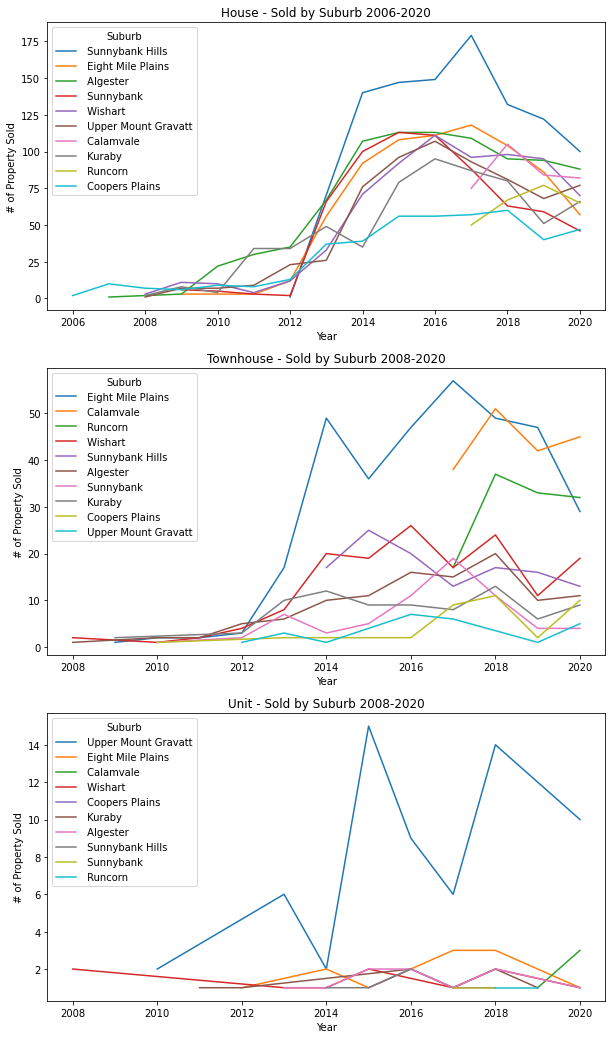

In [93]:
#Create 3 line charts to show the overall propeties sold trend by top 3 property types

fig = plt.figure(figsize=(10,18))

for x in range(3):
    ax=fig.add_subplot(3,1,x+1)
    yr_max=df_type_sold_list[x].index.max()
    yr_min=df_type_sold_list[x].index.min()
    p_type=p_types[x]
    ax=(sns.lineplot(data=df_type_sold_list[x], x='Sold_year', y='Address', hue='Suburb')
    .set_title(str(p_type)+' - Sold by Suburb ' +str(yr_min)+'-'+str(yr_max)))
    plt.ylabel("# of Property Sold")
    plt.xlabel("Year")

By Now we have delivered a data viz to answer the first question
- Over the last 14 years (2006-2020), how many properties are sold yearly by the top 3 property types?


In [94]:
df_sold_yearly=df_sold_yearly.reset_index()
df_sold_yearly

Sold_year  House  Townhouse  Unit
0       2011     91        6.0   1.0
1       2012    132       18.0   2.0
2       2013    334       53.0   8.0
3       2014    660      114.0   7.0
4       2015    804      109.0  22.0
5       2016    853      138.0  19.0
6       2017    952      199.0  14.0
7       2018    885      233.0  26.0
8       2019    776      172.0  17.0
9       2020    698      177.0  16.0

Text(0.5, 0, 'Year')

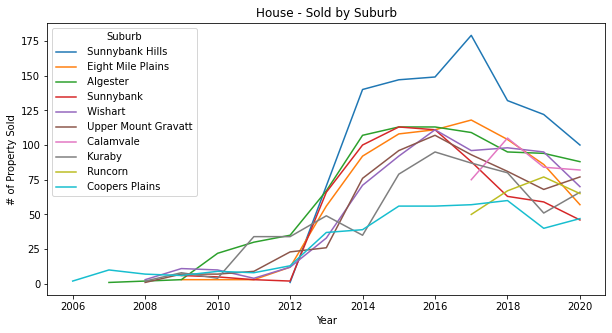

In [95]:
fig = plt.figure(figsize=(10,5))

ax=fig.add_subplot()
ax=(sns.lineplot(data=df_type_sold_list[0], x='Sold_year', y='Address', hue='Suburb')
.set_title('House - Sold by Suburb'))
plt.ylabel("# of Property Sold")
plt.xlabel("Year")

### Summary##

- **Sunnybank Hills** had the most **Houses** sold between 2006-2020.
- **Eight Mile Plains** had the most **Townhouses** sold from 2008-2020.
- **Upper Mountt Gravatt** had the most **Units** sold from 2008-2020.
- This observed trend is in line with the new Units/Apartments development in these suburbs over the last decade, while land is becoming a rare resources in Brisbane urban area.

<font color='blue'>Now, let's check the houses sold by number of bedrooms, because this is the property type that our clients are most interested in.<br>
Also, we will zoom in on the sold property over the last 4 years (2017-2020). This is because we can see from the above shown house chart, that some of the key suburbs (Runcorn and Calamvale), only had the house data available from 2017 onwards.</font>

In [96]:
#First, narrow down the data to the years between 2017-2020
#last_4_yrs_cond=(df_all.Sold_year==2017)|(df_all.Sold_year==2018)|(df_all.Sold_year==2019)|(df_all.Sold_year==2020)
last_4_yrs_cond=(df_all.Sold_year>=2017)&(df_all.Sold_year<=2020)
df_last_4_yrs=df_all[last_4_yrs_cond]

#Second,narrow down the data to House type only
house=df_last_4_yrs.Type=='House'
df_last_4_yrs_house=df_last_4_yrs[house]

#Now, over the last 4 years, there are a total of 3319 rows of record of sold houses
df_last_4_yrs_house.shape  

(3311, 16)

In [97]:
df_last_4_yrs_house.head(3)

Address  \
0     58 Dalmeny Street, Algester   
1     162 Delathin Road, Algester   
2  20 Springwater Place, Algester   

                                       Property_Info  \
0  https://www.realestate.com.au/sold/property-ho...   
1  https://www.realestate.com.au/sold/property-ho...   
2  https://www.realestate.com.au/sold/property-ho...   

                                          Agent_logo  \
0  https://i2.au.reastatic.net/340x64/d4ded41d266...   
1  https://i2.au.reastatic.net/340x64/72065f86a98...   
2  https://i2.au.reastatic.net/340x64/adf93bc0d60...   

                           Agent  \
0  Michelle Huston & Mark Kearns   
1                    JJ Macalino   
2                  Andrea Manson   

                                         Agent_photo Status  Bedrooms  \
0  https://i2.au.reastatic.net/150x200/8a5badd53f...   Sold       2.0   
1  https://i2.au.reastatic.net/150x200/ff4dfb2ff3...   Sold       4.0   
2  https://i2.au.reastatic.net/150x200/d84dba8712...   Sold       4.0   

   Bathrooms  Car_park Size_unit   Type  Sold_date     Suburb     Price  \
0        2.0       2.0        m²  House 2020-12-15   Algester  700000.0   
1        2.0       2.0        m²  House 2020-12-11   Algester  600000.0   
2        3.0       2.0        m²  House 2020-12-11   Algester  577800.0   

    Size  Sold_year  
0  549.0       2020  
1  570.0       2020  
2  604.0       2020

In [98]:
df_last_4_yrs_house.Suburb.value_counts()

 Sunnybank Hills        533
 Algester               386
 Eight Mile Plains      365
 Wishart                359
 Calamvale              346
 Upper Mount Gravatt    319
 Kuraby                 284
 Runcorn                259
 Sunnybank              256
 Coopers Plains         204
Name: Suburb, dtype: int64

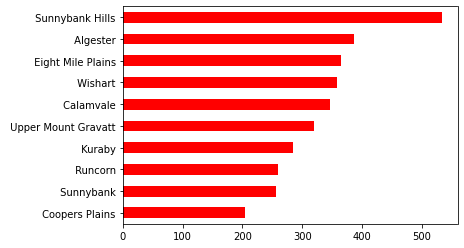

In [99]:
#See the last 4 years, how many houses were sold in each suburb
df_last_4_yrs_house['Suburb'].value_counts().plot(kind='barh', color='r').invert_yaxis()

In [100]:
"""Now we noticed some small issues:
There are many different number of Bedrooms from 3-7 etc.But our clients are only interested in bedrooms 3-4, 
Also, they want to have a rough idea on the bedrooms 5+ trend, 
So we will need to roll up the bedsrooms into a new column "Bedroom_Category" to simplify the view """

df_last_4_yrs_house.groupby(['Sold_year','Suburb', 'Bedrooms']).Address.count()

Sold_year  Suburb                Bedrooms
2017        Algester             3.0         52
                                 4.0         48
                                 5.0          8
                                 6.0          1
            Calamvale            3.0         16
                                             ..
2020        Upper Mount Gravatt  7.0          1
            Wishart              3.0         29
                                 4.0         28
                                 5.0         11
                                 6.0          2
Name: Address, Length: 208, dtype: int64

In [101]:
#See the number of sold houses by number of bedrooms
df_last_4_yrs_house.Bedrooms.value_counts()

4.0     1364
3.0     1174
5.0      582
6.0      111
2.0       51
7.0       17
8.0        6
9.0        2
1.0        2
11.0       1
10.0       1
Name: Bedrooms, dtype: int64

In [102]:
# create a condition for our new Bedroom_category column
conditions=[
    (df_last_4_yrs_house.Bedrooms<=2.0),
    (df_last_4_yrs_house.Bedrooms==3.0),
    (df_last_4_yrs_house.Bedrooms==4.0),
    (df_last_4_yrs_house.Bedrooms>=5.0)   
]

In [103]:
# create a category of the values we want to assign for each condition

category=['2 beds or less', '3 beds', '4 beds','5 beds+']

In [104]:
# create a new column and use np.select to assign values to it using our lists as arguments
Bedroom_Category=np.select(conditions, category)

pd.set_option("mode.chained_assignment", None) #to turn off the raise copy warning issue

df_last_4_yrs_house.loc[:,'Bedroom_Category']=Bedroom_Category

In [105]:
df_last_4_yrs_house['Bedroom_Category'].head()

0    2 beds or less
1            4 beds
2            4 beds
3            3 beds
4            4 beds
Name: Bedroom_Category, dtype: object

### Q2.How many houses were sold by bedroom numbers?

In [106]:
#Create a dataframe to show the sold properties # by Bedroom Category
df_bedroom_category=df_last_4_yrs_house['Bedroom_Category'].value_counts()
df_bedroom_category=pd.DataFrame(df_bedroom_category).reset_index()
df_bedroom_category.columns=['Beds', '# of Sold Properties']
df_bedroom_category.head()

Beds  # of Sold Properties
0          4 beds                  1364
1          3 beds                  1174
2         5 beds+                   720
3  2 beds or less                    53

In [107]:
#Create a bar chart 
fig=px.bar(df_bedroom_category, x='Beds', 
           y='# of Sold Properties', color='Beds',
           title='Total # of Houses Sold by Bedrooms [2017-2020]',
          width=600, height=400)
fig.show()

In [108]:
#Create a dataframe to show the sold properties # by Suburb and Bedroom Category

df_bedroom_category1=df_last_4_yrs_house[['Suburb','Bedroom_Category']].value_counts()
df_bedroom_category1=pd.DataFrame(df_bedroom_category1).reset_index()
df_bedroom_category1.columns=['Suburb', 'Beds', '# of Sold Properties']
df_bedroom_category1.head()

Suburb    Beds  # of Sold Properties
0       Sunnybank Hills  4 beds                   203
1             Calamvale  4 beds                   198
2       Sunnybank Hills  3 beds                   190
3   Upper Mount Gravatt  3 beds                   189
4              Algester  3 beds                   184

In [109]:
fig=px.bar(df_bedroom_category1, y='Beds', 
           x='# of Sold Properties', color='Suburb',
           title='Total # of Houses Sold by Bedrooms [2017-2020]',
          width=700, height=400)
fig.show()

In [110]:
#Create a new grouped view and turn it into a dataframe
#This time we group the last 4 years data by Suburb, then Sold_year, and 'Bedroom_Category'

groups3=df_last_4_yrs_house.groupby(['Suburb','Sold_year','Bedroom_Category']).Address.count().sort_values(ascending=False)
df_last_4_yrs_beds=pd.DataFrame(groups3).reset_index()

In [111]:
suburbs10=df_last_4_yrs_beds.Suburb.unique().tolist()
year=df_last_4_yrs_beds.Sold_year.unique().tolist()

In [112]:
df_suburb_beds_list=[] #create an empty list to capture each suburb dataframe

for x in suburbs10:
    df_beds=df_last_4_yrs_beds[df_last_4_yrs_beds['Suburb']==x] 
    #create a dataframe for each suburb with sold houses with different number of bedrooms
    df_suburb_beds_list.append(df_beds)  

In [113]:
df_suburb_beds_list[0]

Suburb  Sold_year Bedroom_Category  Address
0     Sunnybank Hills       2017           4 beds       66
1     Sunnybank Hills       2017           3 beds       65
7     Sunnybank Hills       2018           4 beds       48
12    Sunnybank Hills       2019           4 beds       47
13    Sunnybank Hills       2017          5 beds+       47
16    Sunnybank Hills       2018           3 beds       46
22    Sunnybank Hills       2019           3 beds       43
26    Sunnybank Hills       2020           4 beds       42
31    Sunnybank Hills       2018          5 beds+       37
33    Sunnybank Hills       2020           3 beds       36
47    Sunnybank Hills       2019          5 beds+       30
71    Sunnybank Hills       2020          5 beds+       21
133   Sunnybank Hills       2019   2 beds or less        2
134   Sunnybank Hills       2020   2 beds or less        1
137   Sunnybank Hills       2018   2 beds or less        1
140   Sunnybank Hills       2017   2 beds or less        1

Text(0.5, 0, 'Year')

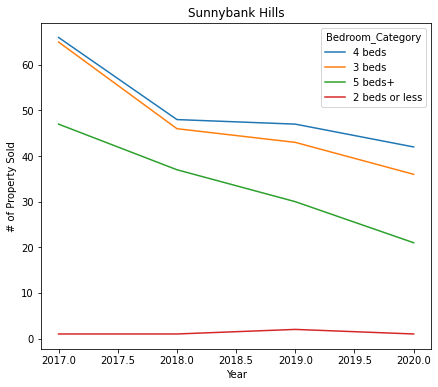

In [114]:
# The line chart below shows you the the legend info for Sunnybank
# Because I visualize the 10 suburbs sold properties data in a 5x2 plots, which is easier to splot the trend across suburbs.
# But the number of subplots made it difficult to see the legend info 

fig = plt.figure(figsize=(7,6))
ax=fig.add_subplot()
ax=sns.lineplot(data=df_suburb_beds_list[0], x='Sold_year', y='Address', hue='Bedroom_Category').set_title('Sunnybank Hills')
plt.ylabel("# of Property Sold")
plt.xlabel("Year") 
# plt.show()

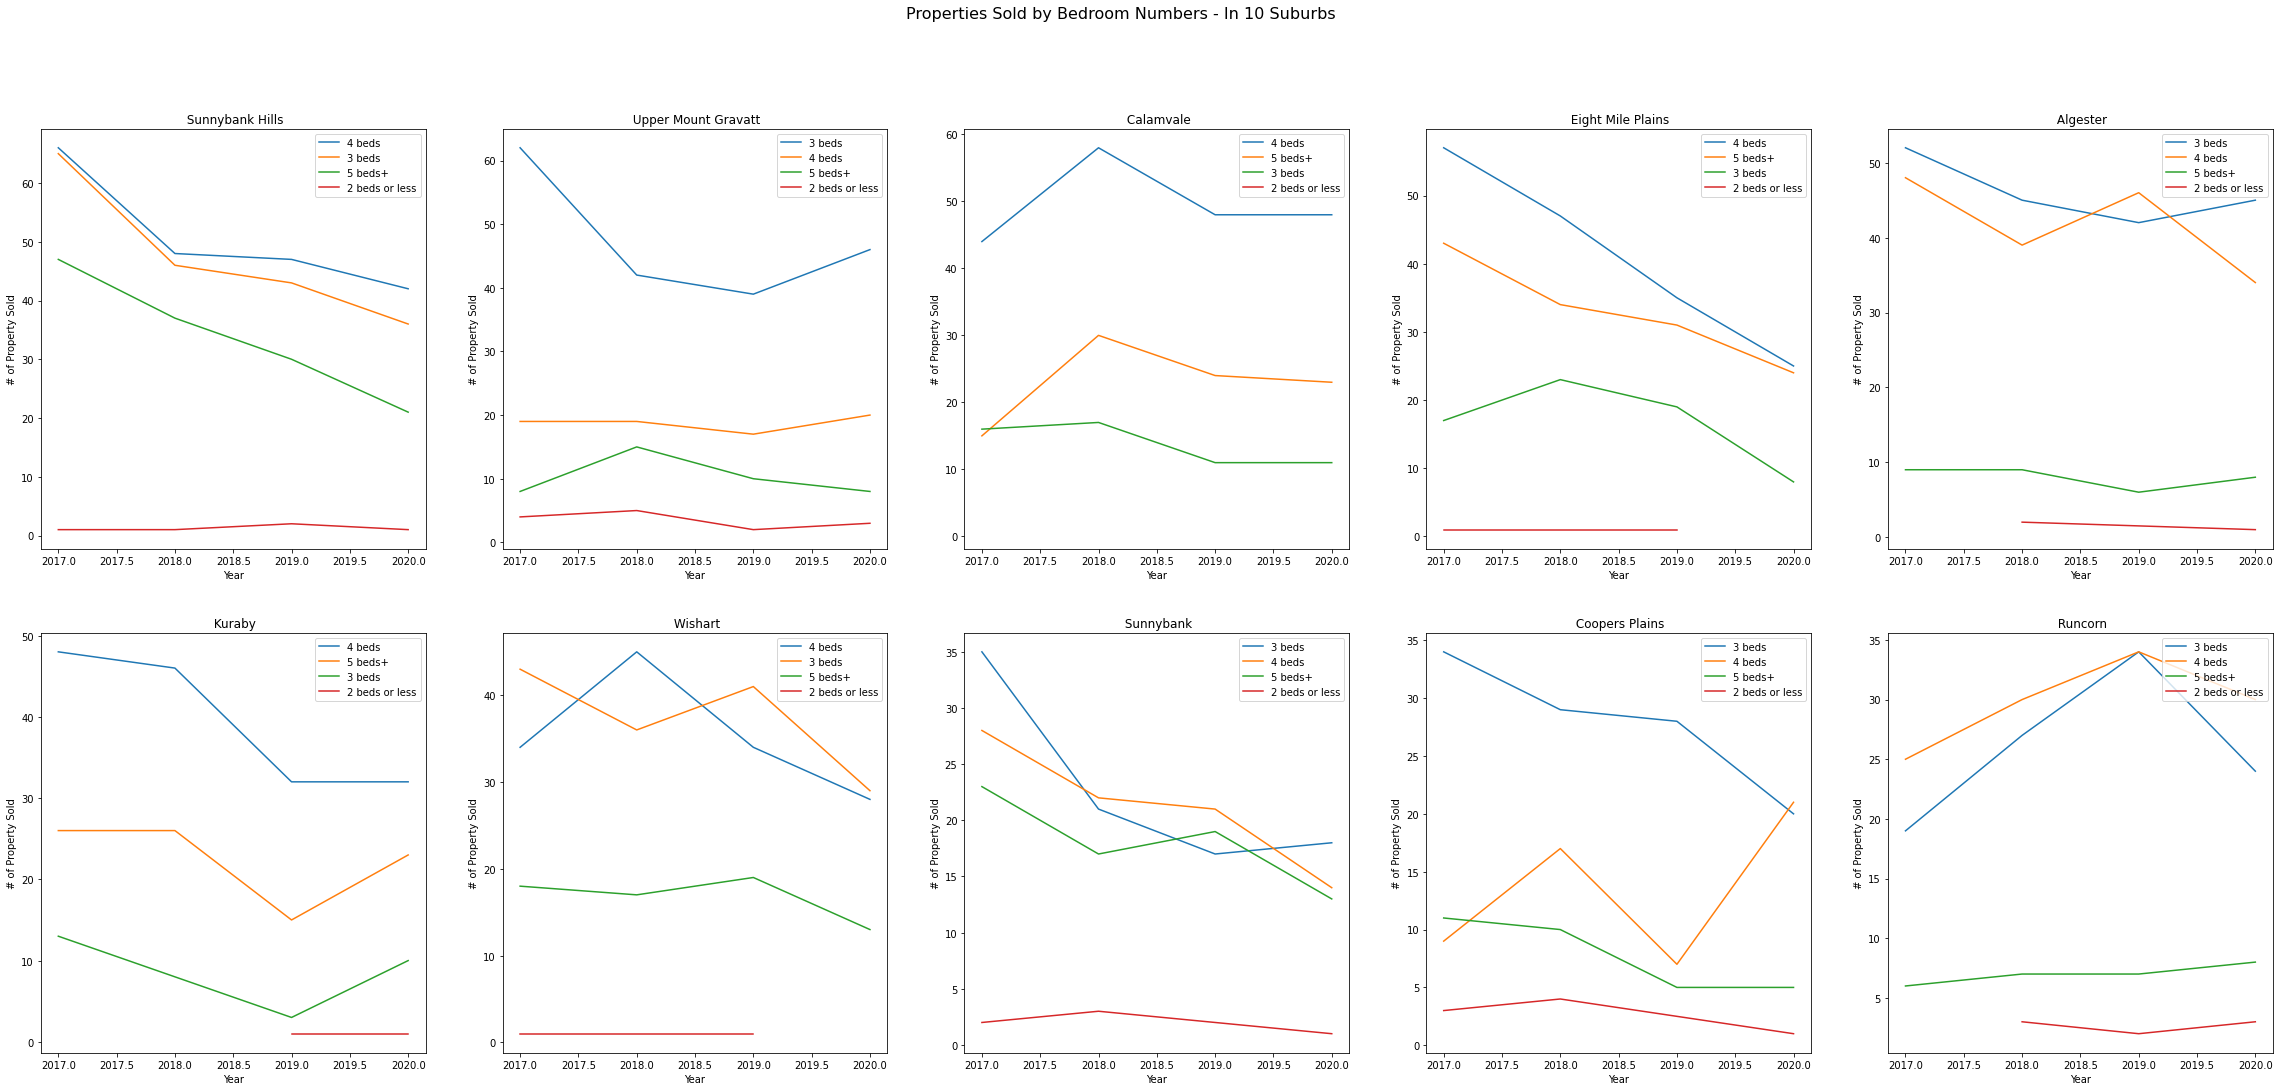

In [115]:
#Build a properties sold by Bedrooms Number view for each suburb using a loop

fig = plt.figure(figsize=(40,17))
fig.suptitle("Properties Sold by Bedroom Numbers - In 10 Suburbs", fontsize=16)
for x in range(10):
   
    ax=fig.add_subplot(2,5,x+1)
    suburbname=suburbs10[x]
    ax=sns.lineplot(data=df_suburb_beds_list[x], x='Sold_year', y='Address', hue='Bedroom_Category').set_title(str(suburbname))
    plt.ylabel("# of Property Sold")
    plt.xlabel("Year") 
    plt.legend(loc='upper right')

# plt.show()
fig.savefig('Property_Sold_Suburb.png', dpi=700)

### <font color='blue'>Summary </font>


**Q2.How many houses were sold by bedroom numbers?**

- Over the past 4 years, **1.4K 4-Bedroom houses** were sold<br>
- Followed by 1.2K 3-Bedrooms, 720 5+ Bedrooms, and 53 houses with 2 or less bedrooms. <br> 
- **Sunnybank Hills** sold the most houses with 3, 4, and 5+ bedrooms (190, 203, 135). 
 
 
**Q2.1- What is the sold properties trend among these suburbs?** 
- 5 Suburbs (Sunnybank Hills, Sunnybank, Wishart, Eight Mile Plains, Runcorn) saw a declining trend of the number of houses sold in all bedroom numbers from 2017-2020.<br> 
- 3 Suburbs (Algester, Calamvale) had relatively flat trend in the number of houses sold during this time.<br>
- 2 Suburbs (Kuraby, Upper Mount Gravatt) saw an upward trend in sold houses.<br>
- 1 Suburb (Coopers Plains) saw a declining number of houses sold, except 4 beds saw a strong increase from 2019.<br>
- In short, this may indicate the demand of houses in the **5 Suburbs (Eight Mile Plains, Runcorn, Sunnybank, Sunnybank Hills, Wishart)** have increased over the years, as they are known as highly sought-after suburbs in South Eastern Brisbane.<br> 

This may also explain why the houses sold in other 5 suburbs have gone up (by various degrees) as buyers started to look for houses available in the nearby suburbs.<br>

Next, we will need to look at the trend of median houses price sold in those suburbs and see if there's a correlation between the sold median price and the sold house number.
  


### Q3. What is the max, min, and median sold price for House with 3 or 4 bedrooms in each suburb?

Now we are going to further narrow down the data we have to houses sold with only 3 or 4 bedrooms in these 10 subrubs in the past 4 years.

In [116]:
df_last_4_yrs_house.shape

(3311, 17)

In [117]:
suburbs10

[' Sunnybank Hills',
 ' Upper Mount Gravatt',
 ' Calamvale',
 ' Eight Mile Plains',
 ' Algester',
 ' Kuraby',
 ' Wishart',
 ' Sunnybank',
 ' Coopers Plains',
 ' Runcorn']

In [118]:
# Only select data contains to houses sold with only 3 or 4 bedrooms in these 10 subrubs

df_34_beds=df_last_4_yrs_house[(df_last_4_yrs_house['Bedroom_Category']=='3 beds')|(df_last_4_yrs_house['Bedroom_Category']=='4 beds')]

In [119]:
df_suburb_34_beds_list=[] #create an empty list to capture each suburb dataframe

for x in suburbs10:
    df_34_bed=df_34_beds[df_34_beds['Suburb']==x] #create a dataframe for each suburb with sold houses with 3 or 4 bedrooms
    df_suburb_34_beds_list.append(df_34_bed) 

In [120]:
#This method is mutually exclusive from plot.show(), I have to use this one to show the plot express chart below
matplotlib.use('PS')

In [121]:
#This is a script to show boxplot for 10 charts, but the view is too small to see. 

# fig = plt.figure(figsize=(70,75))
# fig.suptitle("Properties Sold Price - In 10 Suburbs", fontsize=16)

# for x in range(10):
#     ax=fig.add_subplot(5,2,x+1)    
#     suburbname=suburbs10[x]
#     ax=sns.boxplot(data=df_suburb_34_beds_list[x], x='Sold_year', y='Price', hue='Bedroom_Category')
#     plt.ylabel("Price")
#     plt.xlabel("Year") 
#     plt.legend(loc='upper right')
#plt.show()
                   

As the traditional boxplot for 10 suburbs can be very busy to view the pattern, I have created 10 box plots to the sold house price:
- min, max, median for 3 beds and 4 beds sperately
- also show the viz in an interactive format, which allows the use to click on the legend to filter the view. 

In [122]:
#use plotly express to show 10 interactive boxplots of the min, max, median price from each suburb

for x in range(10):
   
    suburbname=suburbs10[x]
    ax=(px.box(df_suburb_34_beds_list[x], x='Sold_year', y='Price',color='Bedroom_Category' , 
              title='House Price - '+str(suburbname) +" [2017-2020]", width=700, height=390))
    ax.show()


In [123]:
#Still, we find it a bit hard to see the median price in the boxplots, 
#so let's use line chart to see the median price change over the time for all 10 suburbs
data=df_34_beds

fig3=px.box(data, x='Sold_year', y='Price',color='Bedroom_Category' , 
              title="House Price - All 10 Suburbs" +" [2017-2020]", width=700, height=500, notched=True)

fig3.show()

In [124]:
#Use one suburb as an example to show its median price
Sunnybank_hills=df_suburb_34_beds_list[0]
medianPrice_suburb=Sunnybank_hills.groupby(['Bedroom_Category']).Price.median()
medianPrice_suburb_3bd=medianPrice_suburb['3 beds']
medianPrice_suburb

Bedroom_Category
3 beds    559000.0
4 beds    675000.0
Name: Price, dtype: float64

In [125]:
#create a df with only house price for 3 bedrooms in 10 suburbs

df_3_beds=df_34_beds[df_34_beds['Bedroom_Category']=='3 beds']

#create a df with only house price for 4 bedrooms in 10 suburbs

df_4_beds=df_34_beds[df_34_beds['Bedroom_Category']=='4 beds']

In [126]:
#Get the sold median price for 3-bedrooms
df_3_beds_medianPrice=df_3_beds.groupby(['Suburb']).Price.median()
df_3_beds_medianPrice=df_3_beds_medianPrice.sort_values(ascending=False)
df_3_beds_medianPrice

Suburb
 Sunnybank              655000.0
 Wishart                654500.0
 Eight Mile Plains      615100.0
 Upper Mount Gravatt    602000.0
 Sunnybank Hills        559000.0
 Coopers Plains         545000.0
 Calamvale              538000.0
 Runcorn                532500.0
 Algester               480000.0
 Kuraby                 431000.0
Name: Price, dtype: float64

In [127]:
#Get the sold median price for 4-bedrooms
df_4_beds_medianPrice=df_4_beds.groupby(['Suburb']).Price.median()
df_4_beds_medianPrice=df_4_beds_medianPrice.sort_values(ascending=False)
df_4_beds_medianPrice

Suburb
 Wishart                765000.0
 Sunnybank              752000.0
 Eight Mile Plains      750000.0
 Upper Mount Gravatt    721693.0
 Kuraby                 680000.0
 Sunnybank Hills        675000.0
 Calamvale              650000.0
 Coopers Plains         634000.0
 Runcorn                606888.0
 Algester               556000.0
Name: Price, dtype: float64

In [128]:
#Bar chart for 3-bedroom median price by suburb

fig_3_beds_medianPrice=px.bar(df_3_beds_medianPrice, y='Price',width=700, height=450, 
                              title='3 Bedroom House - Median Price in 10 Suburbs [2017-2020]')
fig_3_beds_medianPrice.update_traces(marker_color='rgb(255, 102, 102)', )
fig_3_beds_medianPrice.show()

In [129]:
#Bar chart for 4-bedroom median price by suburb
fig_4_beds_medianPrice=px.bar(df_4_beds_medianPrice, y='Price',width=700, 
                              height=450,title='4 Bedroom House - Median Price in 10 Suburbs [2017-2020]')
fig_4_beds_medianPrice.update_traces(marker_color='rgb(51, 204, 204)')
fig_4_beds_medianPrice.show()

#### <font color='blue'>Summary</font>

**<font color='blue'>Houses Median Price have been stable over last 4 years among 10 suburbs:</font>** <br>
- The median price for 3-bedroom house has been around 560-575k.
- The median price for 4-bedroom house has been around 660-690k.


**<font color='blue'>Houses sold with 3 bedrooms [2017-2020]:</font>** <br>
- 2 suburbs (Sunnybank and Wishart) saw the highest median price of 655K (AUD).<br> 
- Eight Mile Plains, Upper Mount Gravatt ranked the 2nd highest with a median price of low 600K.<br> 
- Sunnybank Hills, Coopers Plains, Calamvale and Runcorn had a median price of low-high 500K.<br> 
- Kuraby and Algester sit on the lower rank with a median price low to high 400K, with Kuraby being the lowest of 431K.<br>    
    

**<font color='blue'>Houses sold with 4 bedrooms [2017-2020]:</font>** <br>
- 4 suburbs (Wishart, Sunnybank, Eight Mile Plains, Upper Mount Gravatt) saw the highest median price above 700K (AUD), with Wishart being the most expensive of 765K.<br> 
- Calamvale,Sunnybank Hills and Kuraby had a median price of mid-high 600K.<br> 
- Algester, Runcorn and Coopers Plains sit on the lower rank with a median price of mid 500K- low 600K, with Algester being the lowest of 556K.<br> 


### Q4. Are there any correlations between the house sold price and other factors?

In [130]:
df_all=df_all[df_all['Type']=='House'] #only select houses data
df_all.shape

(6317, 16)

In [131]:
Size_not0=(df_all.Size!=0) # remove any houses that the size value is missing
df_all=df_all[Size_not0] # we have 5.6K properties with valid size values for data viz
df_all.shape

(5622, 16)

In [132]:
df_all=df_all.sort_values(by='Sold_year', ascending=True) #sort the dataframe by Column=Sold_year
df_all.head(3)

Address  \
2079   18 Delph Street, Coopers Plains   
2078     49 Keeling St, Coopers Plains   
2075  35 Middle Street, Coopers Plains   

                                          Property_Info  \
2079  https://www.realestate.com.au/sold/property-ho...   
2078  https://www.realestate.com.au/sold/property-ho...   
2075  https://www.realestate.com.au/sold/property-ho...   

                                             Agent_logo                 Agent  \
2079  https://i2.au.reastatic.net/340x64/683b259b844...               unknown   
2078  https://i2.au.reastatic.net/340x64/683b259b844...  Agent: Robyn Kennedy   
2075  https://i2.au.reastatic.net/340x64/683b259b844...  Agent: Robyn Kennedy   

     Agent_photo Status  Bedrooms  Bathrooms  Car_park Size_unit   Type  \
2079     unknown   Sold       3.0        1.0       1.0        m²  House   
2078     unknown   Sold       4.0        2.0       3.0        m²  House   
2075     unknown   Sold       3.0        2.0       2.0        m²  House   

      Sold_date           Suburb     Price   Size  Sold_year  
2079 2007-02-14   Coopers Plains  260000.0  569.0       2007  
2078 2007-06-11   Coopers Plains  440000.0  809.0       2007  
2075 2007-07-19   Coopers Plains  345001.0  629.0       2007

In [141]:
#Let's create a scatterplot to check if there's any correlation between the House price vs the Propety Size

fig4=px.scatter(df_all, x='Price', y='Size',color="Bedrooms", 
                  animation_frame='Sold_year',  
                  range_x=[0,3000000], range_y=[0,3300],
                  title="House Price vs Size - All 10 Suburbs" +" [2017-2020]", width=650, height=700)

fig4.show()

In [134]:
#Create a correlation table with the df_all dataframe

df_corr=df_all.corr(method='pearson')
df_corr

Bedrooms  Bathrooms  Car_park     Price      Size  Sold_year
Bedrooms   1.000000   0.690448  0.237440  0.480690  0.140062   0.055234
Bathrooms  0.690448   1.000000  0.254994  0.532292  0.133146   0.054990
Car_park   0.237440   0.254994  1.000000  0.300112  0.219995   0.104674
Price      0.480690   0.532292  0.300112  1.000000  0.581953   0.152446
Size       0.140062   0.133146  0.219995  0.581953  1.000000  -0.020301
Sold_year  0.055234   0.054990  0.104674  0.152446 -0.020301   1.000000

In [135]:
#Creat a heatmap to visualize the dataframe and co-efficency values
fig, ax = plt.subplots(figsize=(8, 7))
ax=sns.heatmap(df_corr, cmap="YlGnBu",annot=True)

#### <font color='blue'>Summary</font>

**<font color='blue'>Correlation between House Price vs Property Size, Bedrooms, Bathrooms, Car Parks</font>** <br>

- House price showed the **highest linear correlation** with the **Property Size (r - 0.58)**, <br>
- Followed by its correlation with the **Number of Bathrooms (r - 0.53)** and then the **Number of Bedrooms (r - 0.48)**.<br>
- There's no strong correlation between the House Price and the Number of Car Parks.

# <font color='#d73a49'> Conlusion </font>


1. The above analysis shows the supply (the number of sold houses) is declining. This could be a result of the high demand for 3-4 bedroom house in theses areas, where the house price is likely to continue to rise in next few years.

  - **<font color='#blue'> High Price, High Demand Suburbs : Eight Mile Plains, Sunnybank, Sunnybank Hills, Wishart</font>**<br><br>

2. By Comparing the number of houses sold, and the median price of houses across 10 suburbs, it's recommended that the clients to consider exploring houses in the following 5 suburbs:
  
  - **<font color='#blue'>Algester, Calamvale, Coopers Plains, Kuraby</font>**, which showed a stable/increase # of houses sold, but the median price is still within the affordable range (high 500K - mid 600K) for the couple.

  - **<font color='#blue'>Runcorn</font>**, (a popular suburb adjacent to Sunnybank, Sunnybank Hills, Eight Mile Plains), has started to show a declining number of houses sold since 2019. This indicates the demand has increased significantly last year, but the median price is still between mid 500K to low 600K for 3 and 4 bedroom houses. Enter this suburb early may help the couple to benefit from long-term capital growth.<br><br>
   
3. If the family prefers a 3 bed-room house at a lower price, then watch the new properties coming to the market in the following areas:  
   - **<font color='#blue'>Calamvale, Runcorn, Algester and Kuraby (Median price range - 430K - 530K)</font>**  
     
 4. If the family prefers a 4 bed-room house at a lower price, then watch the new properties coming to the market in the following areas:
  
   - **<font color='#blue'>Calamvale, Coopers Plains, Runcorn, Algester (Median price range - 560K - 650K)</font>** 

Access a clear image via this **['link'](https://raw.githubusercontent.com/nikki099/Coder_Academy_Projects/main/Final_Project/Data/Property_Sold_Suburb.jpg?token=ALBK3TP3DMD7E237UYHB76C74CGS6)**<br>
- Note: zoom in to 110% to view the image properly

![Trend](https://raw.githubusercontent.com/nikki099/Coder_Academy_Projects/main/Final_Project/Data/Property_Sold_Suburb.jpg?token=ALBK3TP3DMD7E237UYHB76C74CGS6)


#  <font color='#0366d6'> Follow-up analysis </font>

To help the couple make an informed choice, it's recommended to continue exploring the following data to gain a better understanding of the recommended suburbs:
   - Demographics (Population, Household Types, Age groups, House Ownerships, Ethnic Communities)
   - Distances to local suburbs, shops and public transportations
   - Suburb crime rate
   
  